# Generalizing trajectories

<img align="right" src="https://anitagraser.github.io/movingpandas/assets/img/movingpandas.png">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/anitagraser/movingpandas-examples/main?filepath=1-tutorials/7-generalizing-trajectories.ipynb)
[![IPYNB](https://img.shields.io/badge/view-ipynb-hotpink)](https://github.com/anitagraser/movingpandas-examples/blob/main/1-tutorials/7-generalizing-trajectories.ipynb)
[![HTML](https://img.shields.io/badge/view-html-green)](https://anitagraser.github.io/movingpandas-website/1-tutorials/7-generalizing-trajectories.html)

To reduce the size (number of points) of trajectory objects, we can generalize them, for example, using:

- Spatial generalization, such as Douglas-Peucker algorithm
- Temporal generalization by down-sampling, i.e. increasing the time interval between records
- Spatiotemporal generalization, e.g. using Top-Down Time Ratio algorithm

[Documentation](https://movingpandas.readthedocs.io/en/master/trajectorygeneralizer.html)

A closely related type of operation is [trajectory smoothing which is coverd in a separate notebook](./10-smoothing-trajectories.ipynb). 

In [14]:
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import movingpandas as mpd
import pandas as pd
from holoviews import opts

sys.path.append('../../pymeos/')
from pymeos import TPointInst, TGeogPointInst, TGeogPointSeq, meos_initialize

plot_defaults = {'linewidth': 5, 'capstyle': 'round', 'figsize': (9, 3), 'legend': True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))
meos_initialize()

In [4]:
pdf = pd.read_csv('../data/aisinput.csv')
gdf = gpd.GeoDataFrame(pdf.drop(['latitude', 'longitude'], axis=1),
                       geometry=gpd.points_from_xy(pdf.longitude, pdf.latitude), crs=4326)
traj_collection = mpd.TrajectoryCollection(gdf, 'mmsi', t='t')

In [5]:
original_traj = traj_collection.trajectories[1]
print(original_traj)

Trajectory 219027804 (2021-01-08 00:00:01 to 2021-01-08 23:59:56) | Size: 38326 | Length: 67296.6m
Bounds: (11.76856, 55.82208, 12.060407, 55.94418)
LINESTRING (11.866278 55.94244, 11.866278 55.94244, 11.866278 55.94244, 11.86628 55.94244, 11.86628 


/home/diviloper/.virtualenvs/pymeos_examples/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

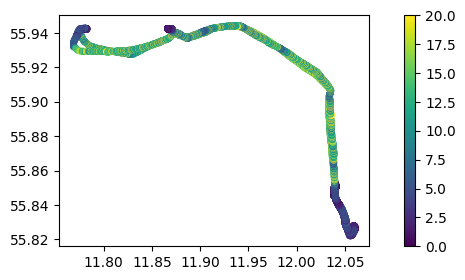

In [6]:
original_traj.plot(column='speed', vmax=20, **plot_defaults)

In [7]:
def create_point(row) -> TPointInst:
    return TGeogPointInst(string=f"{row['geometry']}@{row.name}")


original_traj.df['MEOS Point'] = original_traj.df.apply(create_point, axis=1)

In [8]:
sequence = TGeogPointSeq(instant_list=original_traj.df['MEOS Point'], normalize=False)

Count: 38326


/home/diviloper/.virtualenvs/pymeos_examples/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

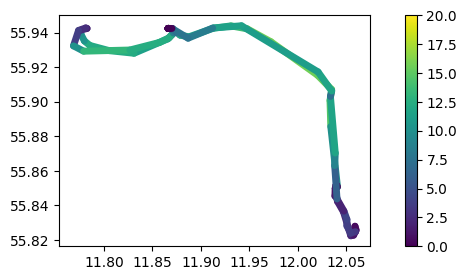

In [9]:
dp_generalized = mpd.DouglasPeuckerGeneralizer(original_traj).generalize(tolerance=0.001)
dp_generalized.plot(column='speed', vmax=20, **plot_defaults)

In [10]:
dp_generalized_pymeos = sequence.simplify(synchronized=False, tolerance=0.001).to_trajectory()
dp_generalized_pymeos.plot(column='speed', vmax=20, **plot_defaults)

TypeError: an integer is required

In [ ]:
dp_generalized

In [ ]:
dp_generalized_pymeos

In [ ]:
print('Original length: %s' % (original_traj.get_length()))
print('Generalized length: %s' % (dp_generalized.get_length()))
print('Generalized PyMEOS length: %s' % (dp_generalized_pymeos.get_length()))

## Spatiotemporal generalization (TopDownTimeRatioGeneralizer)

In [87]:
tdtr_generalized = mpd.TopDownTimeRatioGeneralizer(original_traj).generalize(tolerance=0.001)

In [88]:
tdtr_generalized.df.head()

,mmsi,sog,geometry,MEOS Point
t,,,,
2021-01-08 00:00:01,219027804,0.0,POINT (11.86628 55.94244),POINT(11.866 55.942)@2021-01-08 00:00:01+01
2021-01-08 10:03:09,219027804,0.0,POINT (11.86629 55.94244),POINT(11.866 55.942)@2021-01-08 10:03:09+01
2021-01-08 10:04:55,219027804,2.8,POINT (11.86688 55.94235),POINT(11.867 55.942)@2021-01-08 10:04:55+01
2021-01-08 10:06:37,219027804,5.8,POINT (11.87027 55.94239),POINT(11.87 55.942)@2021-01-08 10:06:37+01
2021-01-08 10:07:15,219027804,24.4,POINT (11.87133 55.94039),POINT(11.871 55.94)@2021-01-08 10:07:15+01


In [89]:
tdtr_generalized_pymeos = sequence.simplify(synchronized=True, tolerance=0.001).to_trajectory()

Let's compare this to the basic Douglas-Peucker result:

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(19, 7))
tdtr_generalized.plot(ax=axes[0][0], column='speed', vmax=20, **plot_defaults)
tdtr_generalized_pymeos.plot(ax=axes[0][1], column='speed', vmax=20, **plot_defaults)
dp_generalized.plot(ax=axes[1][0], column='speed', vmax=20, **plot_defaults)
dp_generalized_pymeos.plot(ax=axes[1][1], column='speed', vmax=20, **plot_defaults)

In [35]:
tdtr_generalized

Trajectory 219027804 (2021-01-08 00:00:01 to 2021-01-08 23:59:56) | Size: 89 | Length: 62991.7m
Bounds: (11.768628, 55.822203, 12.060322, 55.943933)
LINESTRING (11.866278 55.94244, 11.866288 55.94244, 11.866885 55.942353, 11.87027 55.942393, 11.8713

In [36]:
tdtr_generalized_pymeos

Trajectory None (2021-01-08 00:00:01 to 2021-01-08 23:59:56) | Size: 89 | Length: 62991.7m
Bounds: (11.768628, 55.822203, 12.060322, 55.943933)
LINESTRING (11.866278 55.94244, 11.866288 55.94244, 11.866885 55.942353, 11.87027 55.942393, 11.8713

In [53]:
from time import time


def speeds():
    times = 10

    start = time()
    for _ in range(times):
        mpd.DouglasPeuckerGeneralizer(original_traj).generalize(tolerance=0.001)
    end = time()
    dp = (end - start) / times

    start = time()
    for _ in range(times):
        sequence.simplify(synchronized=False, tolerance=0.001).to_trajectory()
    end = time()
    dp_meos = (end - start) / times

    start = time()
    for _ in range(times):
        mpd.TopDownTimeRatioGeneralizer(original_traj).generalize(tolerance=0.001)
    end = time()
    tdtr = (end - start) / times

    start = time()
    for _ in range(times):
        sequence.simplify(synchronized=True, tolerance=0.001).to_trajectory()
    end = time()
    tdtr_meos = (end - start) / times

    return dp, dp_meos, tdtr, tdtr_meos

In [54]:
dp, dp_meos, tdtr, tdtr_meos = speeds()

In [58]:
print(f'Douglas-Peuker MovingPandas: {dp:0.3f}s')
print(f'Douglas-Peuker MovingPandas - PyMEOS: {dp_meos:0.3f}s')
print(f'Douglas-Peuker MovingPandas - PyMEOS speedup: {dp / dp_meos:0.2f}')
print(f'Top-Down Time Ratio MovingPandas: {tdtr:0.3f}s')
print(f'Top-Down Time Ratio MovingPandas - PyMEOS: {tdtr_meos:0.3f}s')
print(f'Top-Down Time Ratio MovingPandas - PyMEOS speedup: {tdtr / tdtr_meos:0.2f}')

Douglas-Peuker MovingPandas: 2.054s
Douglas-Peuker MovingPandas - PyMEOS: 0.016s
Douglas-Peuker MovingPandas - PyMEOS speedup: 125.03
Top-Down Time Ratio MovingPandas: 7.947s
Top-Down Time Ratio MovingPandas - PyMEOS: 0.081s
Top-Down Time Ratio MovingPandas - PyMEOS speedup: 97.97
